# Neural networks
In this notebook, we explore 2 different neural network architectures that succeeded in predicting sales volumes for a kaggle competition.

## Notebook settings

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.stats import describe
import seaborn as sns
from pylab import rcParams
from model import *
from prediction import *
from data_processing import *
from utils import *
sns.set(style='darkgrid', palette='muted')
color_scheme = {
    'red': '#F1637A',
    'green': '#6ABB3E',
    'blue': '#3D8DEA',
    'black': '#000000'
}

# use svg for all plots within inline backend
%config InlineBackend.figure_format = 'svg'

# increase default plot size

rcParams['figure.figsize'] = 8, 6
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


python 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 18:50:55) [MSC v.1915 64 bit (AMD64)]
keras version 2.2.4
tensorflow version 1.12.0


## Loading data
In order for this to work, download all datasets from kaggle competition:  
https://www.kaggle.com/c/demand-forecasting-kernels-only  
and place them in `../data/` folder.  
We could not append datasets to our repo because of copyrights.

In [2]:
df_train = pd.read_csv('../train.csv/train.csv')
df_test = pd.read_csv('../test.csv/test.csv')

Before we do anything, we want to have both sets in a format with 500 sales columns and 1 row for each day.

In [3]:
X, Y, X_test, scaler,df_train, df_test, cols_to_scale, y_cols = generate_data(df_train, df_test )

In [4]:
Y_trans = Y.transpose()
y = Y_trans.values.reshape((500,1825,1))

N= 500
T= 1825
D= 20
           
x = ts_data(N,T,D,X)           

<class 'pandas.core.frame.DataFrame'>
Index: 519 entries, item_10_store_10_sales_past_1 to month_12
Columns: 1825 entries, 2013-01-02 to 2017-12-31
Freq: D
dtypes: float64(1825)
memory usage: 7.2+ MB


In [ ]:
N= 500
T= 90
D= 20
                            
x_test_pros = ts_data(N,T,D,X_test)      

In [5]:
saveFile("x.csv", x)
saveFile("y.csv", y)

In [4]:
x = loadFile("x.csv")
y = loadFile("y.csv")

In [5]:
x_train = x[:,:-365,:]
y_train = y[:,:-365:,:]

In [6]:
print(x_train.shape, y_train.shape)

(500, 1460, 20) (500, 1460, 1)


In [6]:
x_val = x[:,-365:-275,:]
y_val = y[:,-365:-275,:]

In [9]:
print(x_val.shape, y_val.shape)

(500, 90, 20) (500, 90, 1)


# stateful mode

In [15]:
hunits = 20
time_steps = 7
epochs = 20
print_val_every = 365
batch_size = 25
model_stateful, _ = define_model_2(time_steps,
                    hidden_neurons = hunits,
                    batch_size = batch_size,
                    stateful = True
                     )
model_stateful.summary()

smodel = statefulModel(model=model_stateful,print_val_every = print_val_every)

#X = [X1_train,X2_train,X3_train,X4_train,X5_train,X6_train]
#X_val = [X1_val,X2_val,X3_val,X4_val,X5_val,X6_val]

start = time.time()
history_stateful = smodel.fit(x_train, y_train, epochs)

end = time.time()
print("Time Took {:3.2f} min".format((end - start)/60))

batch_input_shape=(25, 7, 20)
__________________________________
Epoch 1
  Training..
__________________________________
Epoch 2
  Training..
__________________________________
Epoch 3
  Training..
__________________________________
Epoch 4
  Training..
__________________________________
Epoch 5
  Training..
__________________________________
Epoch 6
  Training..
__________________________________
Epoch 7
  Training..
__________________________________
Epoch 8
  Training..
__________________________________
Epoch 9
  Training..
__________________________________
Epoch 10
  Training..
__________________________________
Epoch 11
  Training..
__________________________________
Epoch 12
  Training..
__________________________________
Epoch 13
  Training..
__________________________________
Epoch 14
  Training..
__________________________________
Epoch 15
  Training..
__________________________________
Epoch 16
  Training..
__________________________________
Epoch 17
  Training..
__________

In [16]:
time_steps = 1

model_pred1, _ = define_model_2(time_steps,
                    hidden_neurons = hunits,
                    batch_size = batch_size,
                    stateful = True
                     )

model_pred1.load_weights("weights_epoch{:03d}_batch500.hdf5".format(epochs))


y_pred_stateful1 = stateful_prediction( model_pred1, x_val)   #stateful_prediction(mm = model_pred1,X_test = x_val)
y_pred_stateful122= np.squeeze(y_pred_stateful1 )
print(y_pred_stateful122.shape)

# this is just for unscaling
template_df = df_train
template_df['is_test'] = np.repeat(False, template_df.shape[0])
template_df= template_df[-365:-275]
#print(template_df.info )

basic_pred = unscale(y_pred_stateful122.transpose(), scaler, template_df, cols_to_scale, y_cols, toint=True)
y_val = y[:,-365:-275,:]
y_val = y_val.reshape((90,500))
y_val = unscale(y_val,scaler, template_df, cols_to_scale, y_cols,toint=True)

basic_smapes = vector_smape(basic_pred, y_val)#(basic_pred,y_val)
describe(basic_smapes)
#print(len(a))

(500, 90)


DescribeResult(nobs=500, minmax=(20.27762378836293, 30.815797585020988), mean=25.05486367641431, variance=3.5953613271376574, skewness=0.33789750236125093, kurtosis=-0.21763273584651266)

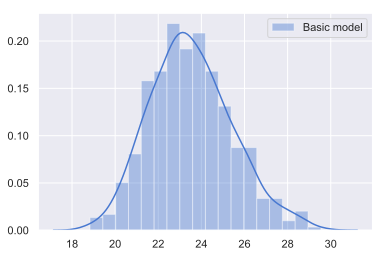

In [52]:
sns.distplot(basic_smapes, label='Basic model')

plt.legend(loc='upper right')

plt.show()


 # stateless

In [17]:
set_seed(sd=123)
hunits = 20
time_steps = 1460 #1825#
epochs = 10
print_val_every = 365
batch_size = 25
model_stateless, _ = define_model_1(time_steps,
                    hidden_neurons = hunits,
                    batch_size = batch_size,
                    stateful = False
                     )

start = time.time()
x_train = x[:,:-365,:]
y_train = y[:,:-365:,:]


#model_stateless.load_weights("model_stateless_weights_epoch{:03d}_batch500.hdf5".format(epochs))
history_stateful = model_stateless.fit(x_train, y_train,batch_size=batch_size, epochs=epochs) #_train

end = time.time()
print("Time Took {:3.2f} min".format((end - start)/60))
model_stateless.save_weights("model_stateless_weights_epoch{:03d}_batch500.hdf5".format(epochs))



Epoch 1/10
500/500 [==============================] - 12s 25ms/step - loss: 0.0229
Epoch 2/10
500/500 [==============================] - 11s 22ms/step - loss: 0.0131
Epoch 3/10
500/500 [==============================] - 11s 22ms/step - loss: 0.0110
Epoch 4/10
500/500 [==============================] - 11s 23ms/step - loss: 0.0102
Epoch 5/10
500/500 [==============================] - 11s 23ms/step - loss: 0.0101
Epoch 6/10
500/500 [==============================] - 11s 23ms/step - loss: 0.0099
Epoch 7/10
500/500 [==============================] - 12s 24ms/step - loss: 0.0098
Epoch 8/10
500/500 [==============================] - 12s 23ms/step - loss: 0.0097
Epoch 9/10
500/500 [==============================] - 12s 23ms/step - loss: 0.0096
Epoch 10/10
500/500 [==============================] - 12s 24ms/step - loss: 0.0096
Time Took 1.93 min


In [22]:
x_val = x[:,-365:-275,:]
y_val = y[:,-365:-275,:]

time_steps = 1

model_pred1, _ = define_model_1(time_steps,
                    hidden_neurons = hunits,
                    batch_size = batch_size,
                    stateful = False
                     )

model_pred1.load_weights("model_stateless_weights_epoch{:03d}_batch500.hdf5".format(epochs))

y_pred_stateful1 = stateless_prediction(model_pred1, x_val,batch_size)   #stateful_prediction(mm = model_pred1,X_test = x_val)
y_pred_stateful122= np.squeeze(y_pred_stateful1)

print(y_pred_stateful122.shape)
# this is just for unscaling
template_df = df_train
template_df['is_test'] = np.repeat(False, template_df.shape[0])
template_df = template_df[-365:-275]

basic_pred = unscale(y_pred_stateful122.transpose(), scaler, template_df, cols_to_scale, y_cols, toint=True)
print(x_val.shape)
#print(template_df.info )
y_val = y[:,-365:-275,:]
y_val = y_val.reshape((90,500))

y_val = unscale(y_val,scaler, template_df, cols_to_scale, y_cols,toint=True)


basic_smapes = vector_smape(basic_pred,y_val)#(y_pred_stateful122.transpose(), y_val)#
describe(basic_smapes)
#print(len(a))


(500, 90)
(500, 90, 20)


DescribeResult(nobs=500, minmax=(90.38714423957185, 103.6357550371275), mean=96.73055592336101, variance=5.5938583664222, skewness=0.00982132751987122, kurtosis=-0.1343791530870435)

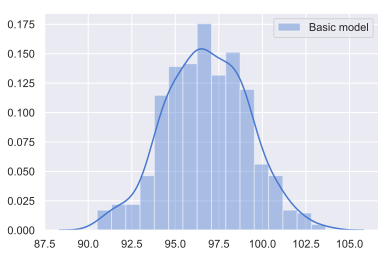

In [49]:
sns.distplot(basic_smapes, label='Basic model')

plt.legend(loc='upper right')

plt.show()


# complex model  stateless

In [7]:
set_seed(sd=123)
hunits = 20
time_steps = 1460 #1825#
epochs = 10
print_val_every = 365
batch_size = 25
model_stateless, _ = define_model_3(time_steps,
                    hidden_neurons = hunits,
                    batch_size = batch_size,
                    stateful = False
                     )

start = time.time()
x_train = x[:,:-365,:]
y_train = y[:,:-365:,:]


#model_stateless.load_weights("model_stateless_weights_epoch{:03d}_batch500.hdf5".format(epochs))
history_stateful = model_stateless.fit(x_train, y_train,batch_size=batch_size, epochs=epochs) #_train

end = time.time()
print("Time Took {:3.2f} min".format((end - start)/60))
model_stateless.save_weights("complex_weights_epoch{:03d}_batch500.hdf5".format(epochs))

Epoch 1/10
500/500 [==============================] - 20s 40ms/step - loss: 0.0701
Epoch 2/10
500/500 [==============================] - 17s 35ms/step - loss: 0.0169
Epoch 3/10
500/500 [==============================] - 17s 34ms/step - loss: 0.0143
Epoch 4/10
500/500 [==============================] - 16s 32ms/step - loss: 0.0131
Epoch 5/10
500/500 [==============================] - 18s 36ms/step - loss: 0.0117
Epoch 6/10
500/500 [==============================] - 17s 35ms/step - loss: 0.0109
Epoch 7/10
500/500 [==============================] - 21s 42ms/step - loss: 0.0099
Epoch 8/10
500/500 [==============================] - 17s 33ms/step - loss: 0.0092
Epoch 9/10
500/500 [==============================] - 17s 34ms/step - loss: 0.0086
Epoch 10/10
500/500 [==============================] - 17s 33ms/step - loss: 0.0083
Time Took 2.98 min


In [40]:
x_val = x[:,-365:-275,:]
y_val = y[:,-365:-275,:]

time_steps = 1

model_pred1, _ = define_model_3(time_steps,
                    hidden_neurons = hunits,
                    batch_size = batch_size,
                    stateful = False
                     )

model_pred1.load_weights("complex_weights_epoch{:03d}_batch500.hdf5".format(epochs))

y_pred_stateful1 = stateless_prediction(model_pred1, x_val, batch_size)   #stateful_prediction(mm = model_pred1,X_test = x_val)
y_pred_stateful122 = np.squeeze(y_pred_stateful1)

print(y_pred_stateful122.shape)
# this is just for unscaling
template_df = df_train
template_df['is_test'] = np.repeat(False, template_df.shape[0])
template_df = template_df[-365:-275]

basic_pred = unscale(y_pred_stateful122.transpose(), scaler, template_df, cols_to_scale, y_cols, toint=True)
print(x_val.shape)
#print(template_df.info )
y_val = y[:,-365:-275,:]

y_val = y_val.reshape((90,500))
y_val = unscale(y_val,scaler, template_df, cols_to_scale, y_cols, toint=True)

basic_smapes = vector_smape(y_pred_stateful122.transpose(), y_val)#(basic_pred,y_val)#
describe(basic_smapes)
#print(len(a))


(500, 90)
(500, 90, 20)


DescribeResult(nobs=500, minmax=(197.52108708319312, 199.6689537221675), mean=199.1466759599339, variance=0.16848115671023445, skewness=-1.0723217888788088, kurtosis=0.6153598185150111)

# complex model stateful

In [54]:
set_seed(sd=222)
hunits = 20
time_steps = 7
epochs = 20
print_val_every = 365
batch_size = 25
model_stateful, _ = define_model_4(time_steps,
                    hidden_neurons = hunits,
                    batch_size = batch_size,
                    stateful = True
                     )
model_stateful.summary()

smodel = statefulModel(model = model_stateful, print_val_every = print_val_every)


start = time.time()
history_stateful = smodel.fit(x, y, epochs)

end = time.time()
print("finished training")
print("Time Took {:3.2f} min".format((end - start)/60))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (25, 7, 20)               0         
_________________________________________________________________
conv1d_31 (Conv1D)           (25, 7, 32)               5152      
_________________________________________________________________
conv1d_32 (Conv1D)           (25, 7, 32)               8224      
_________________________________________________________________
lstm (LSTM)                  (25, 7, 20)               4240      
_________________________________________________________________
time_distributed_42 (TimeDis (25, 7, 1)                21        
Total params: 17,637
Trainable params: 17,637
Non-trainable params: 0
_________________________________________________________________
batch_input_shape=(25, 7, 20)
__________________________________
Epoch 1
  Training..
__________________________________
Epoch 2
  Trainin

In [52]:
time_steps = 1

model_pred1, _ = define_model_4(time_steps,
                    hidden_neurons = hunits,
                    batch_size = batch_size,
                    stateful = True
                     )

model_pred1.load_weights("weights_epoch{:03d}_batch500.hdf5".format(epochs))


y_pred_stateful1 = stateful_prediction( model_pred1, x_val)   #stateful_prediction(mm = model_pred1,X_test = x_val)
y_pred_stateful122 = np.squeeze(y_pred_stateful1 )
print(y_pred_stateful122.shape)

# this is just for unscaling
template_df = df_train
template_df['is_test'] = np.repeat(False, template_df.shape[0])
template_df= template_df[-365:-275]
#print(template_df.info )

basic_pred = unscale(y_pred_stateful122.transpose(), scaler, template_df, cols_to_scale, y_cols, toint=True)
y_val = y[:,-365:-275,:]
y_val = y_val.reshape((90,500))
y_val = unscale(y_val,scaler, template_df, cols_to_scale, y_cols,toint=True)

basic_smapes = vector_smape(basic_pred, y_val)#(basic_pred,y_val)
describe(basic_smapes)
#print(len(a))

(500, 90)


DescribeResult(nobs=500, minmax=(15.871603028421497, 25.96562903867195), mean=21.00812006797809, variance=3.585651474062609, skewness=0.12809281457902238, kurtosis=-0.07357720013105329)

In [ ]:
DescribeResult(nobs=500, minmax=(17.984569786537463, 29.096345360483877), mean=23.657435908593445, variance=3.7231384914625814, skewness=0.012950952871565377, kurtosis=-0.10187555684006844)

# complex model lstm + con1D stateful

In [20]:
hunits = 20
time_steps = 7
epochs = 20
print_val_every = 365
batch_size = 25
model_stateful, _ = define_model_5(time_steps,
                    hidden_neurons = hunits,
                    batch_size = batch_size,
                    stateful = True
                     )
model_stateful.summary()
sys.exit()


smodel = statefulModel(model=model_stateful,print_val_every = print_val_every)

#X = [X1_train,X2_train,X3_train,X4_train,X5_train,X6_train]
#X_val = [X1_val,X2_val,X3_val,X4_val,X5_val,X6_val]

start = time.time()
history_stateful = smodel.fit(x_train, y_train, epochs)

end = time.time()
print("Time Took {:3.2f} min".format((end - start)/60))

ValueError: Cannot reshape a tensor with 800 elements to shape [25,1] (25 elements) for 'reshape_3/Reshape' (op: 'Reshape') with input shapes: [25,1,32], [2] and with input tensors computed as partial shapes: input[1] = [25,1].

In [ ]:
time_steps = 1

model_pred1, _ = define_model_5(time_steps,
                    hidden_neurons = hunits,
                    batch_size = batch_size,
                    stateful = True
                     )

model_pred1.load_weights("weights_epoch{:03d}_batch500.hdf5".format(20))


y_pred_stateful1 = stateful_prediction( model_pred1, x_val)   #stateful_prediction(mm = model_pred1,X_test = x_val)
y_pred_stateful122= np.squeeze(y_pred_stateful1 )
print(y_pred_stateful122.shape)

# this is just for unscaling
template_df = df_train
template_df['is_test'] = np.repeat(False, template_df.shape[0])
template_df= template_df[-365:-275]
#print(template_df.info )

basic_pred = unscale(y_pred_stateful122.transpose(), scaler, template_df, cols_to_scale, y_cols, toint=True)
y_val = y[:,-365:-275,:]
y_val = y_val.reshape((90,500))
y_val = unscale(y_val,scaler, template_df, cols_to_scale, y_cols,toint=True)

basic_smapes = vector_smape(basic_pred, y_val)#(basic_pred,y_val)
describe(basic_smapes)
#print(len(a))

# for test

In [10]:
y_pred_stateful1 = stateful_prediction(mm = model_pred1,X_test = x_test_pros)

In [11]:
y_pred_stateful122= np.squeeze(y_pred_stateful1 )
print(y_pred_stateful122.shape)

(500, 90)


In [12]:
# this is just for unscaling
template_df = df_test
template_df['is_test'] = np.repeat(True, template_df.shape[0])

In [34]:
def unscale(y_arr, scaler, template_df, toint=False):
    """
    Unscale array y_arr of model predictions, based on a scaler fitted 
    to template_df.
    """
    tmp = template_df.copy()
    tmp[y_cols] = pd.DataFrame(y_arr, index=tmp.index)
    tmp[cols_to_scale] = scaler.inverse_transform(tmp[cols_to_scale])
    if toint:
        return tmp[y_cols].astype(int)
    return tmp

In [14]:
basic_pred = unscale(y_pred_stateful122.transpose(), scaler, template_df, toint=True)

In [24]:
basic_pred.head()

,item_10_store_10_sales,item_10_store_1_sales,item_10_store_2_sales,item_10_store_3_sales,item_10_store_4_sales,item_10_store_5_sales,item_10_store_6_sales,item_10_store_7_sales,item_10_store_8_sales,item_10_store_9_sales,...,item_9_store_10_sales,item_9_store_1_sales,item_9_store_2_sales,item_9_store_3_sales,item_9_store_4_sales,item_9_store_5_sales,item_9_store_6_sales,item_9_store_7_sales,item_9_store_8_sales,item_9_store_9_sales
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,27,24,33,28,27,20,21,18,31,27,...,49,39,54,45,47,35,34,32,56,45
2018-01-02,48,40,54,48,47,35,35,31,54,46,...,42,33,44,38,39,29,28,27,47,38
2018-01-03,47,39,53,47,46,34,34,30,52,44,...,42,33,44,38,39,29,28,27,47,38
2018-01-04,52,44,59,53,52,38,38,33,59,50,...,43,34,46,39,40,30,29,28,49,40
2018-01-05,56,47,63,57,55,41,41,36,63,53,...,45,35,48,41,42,32,30,29,51,41


In [43]:
import itertools
def sales_by_storeitem(basic_pred):
    a=[]
    
    for  i, s in product(range(1,51), range(1,11) ):
        #print("store, item",s,i)
        a.append( basic_pred[f'item_{i}_store_{s}_sales'].values  )
        #print(len(set(basic_pred.index.values) ))
        #print((basic_pred.index[basic_pred[f'item_{i}_store_{s}_sales']] ))
        #ids = (basic_pred.index[basic_pred[f'item_{i}_store_{s}_sales']].tolist() )  #item_9_store_7_sales
        #print(basic_pred[f'item_{i}_store_{s}_sales'])
        #print(basic_pred[f'item_{i}_store_{s}_sales'].values)
        #print(len(set(ids)))
    a= list(itertools.chain.from_iterable(a))

    return a

submission3= sales_by_storeitem( basic_pred)

In [125]:
#print("prediction", y_pred_stateful1[0][:-10])
#y_pred = y_pred_stateful1.flatten()
submission = pd.read_csv("../sample_submission.csv")

for idx, row in submission.iterrows():
    #print(idx,row['store'],row['item'])
    #sys.exit()
    row["sales"] =submission3[idx] #y_pred[idx] #np.round(y_pred[idx]).astype(int)
#submission.to_csv("submission.csv", index=False)
print( " submission successful " )

0 1 1


SystemExit: 

For Keras, we need to make further transformations on input values:

## Evaluating model predictions

In [243]:
def model_eval(model, X_test, y_test):
    """
    Evaluate (step-by-step) model predictions from X_test and return predictions and real values in comparable format.
    """
    # prepare data
    sales_x_cols = [col for col in X_test.columns if 'sales' in col]

    sales_x_idxs = [X_test.columns.get_loc(col) for col in sales_x_cols]

    sales_y_cols = [col for col in y_test.columns if 'sales' in col]

    sales_y_idxs = [y_test.columns.get_loc(col) for col in sales_y_cols]
    n_samples = y_test.shape[0]
    y_pred = np.zeros(y_test.shape)
    # iterate
    x_next = X_test.iloc[0].values  #get row values
    
    #sys.exit()
    for i in range(0, n_samples):
        x_arr = np.array([x_next])

        x_arr = x_arr.reshape(x_arr.shape[0], 1, x_arr.shape[1])
        y_pred[i] = model.predict(x_arr)[0] # input for prediction must be 2d, output is immediately extracted from 2d to 1d
        #print("y_pred",  model.predict(x_arr))
        #sys.exit()
        try:
            x_next = X_test.iloc[i+1].values
            x_next[sales_x_idxs] = y_pred[i][sales_y_idxs]

        except IndexError:
            pass  # this happens on last iteration, and x_next does not matter anymore
    return y_pred, y_test.values

In [244]:
def unscale(y_arr, scaler, template_df, toint=False):
    """
    Unscale array y_arr of model predictions, based on a scaler fitted 
    to template_df.
    """
    tmp = template_df.copy()
    tmp[y_cols] = pd.DataFrame(y_arr, index=tmp.index)
    tmp[cols_to_scale] = scaler.inverse_transform(tmp[cols_to_scale])
    if toint:
        return tmp[y_cols].astype(int)
    return tmp[y_cols]


def vector_smape(y_pred, y_real):
    nom = np.abs(y_pred-y_real)
    denom = (np.abs(y_pred) + np.abs(y_real)) / 2
    results = nom / denom
    return 100*np.mean(results)  # in percent, same as at kaggle

In [246]:
y_pred_basic, y_real = model_eval(basic_model, X_valid, y_valid)

In [247]:
# this is just for unscaling
template_df = pd.concat([X_valid, y_valid], axis=1)
template_df['is_test'] = np.repeat(True, template_df.shape[0])

In [248]:
basic_pred = unscale(y_pred_basic, scaler, template_df, toint=True)
#complex_pred = unscale(y_pred_complex, scaler, template_df, toint=True)
real = unscale(y_real, scaler, template_df, toint=True)

In [249]:
basic_smapes = [vector_smape(basic_pred[col], real[col]) for col in basic_pred.columns]
#complex_smapes = [vector_smape(complex_pred[col], real[col]) for col in complex_pred.columns]

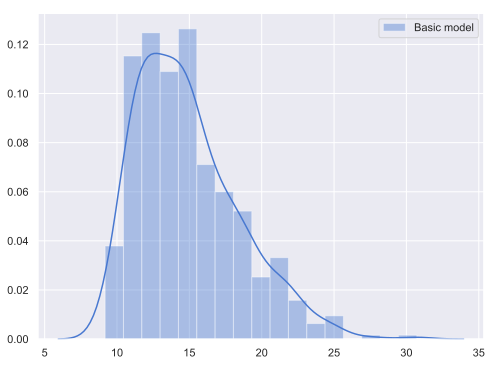

In [250]:
sns.distplot(basic_smapes, label='Basic model')
#sns.distplot(complex_smapes, label='Complex model')
plt.legend(loc='upper right')
plt.savefig('smape_basic_vs_complex.svg')
plt.show()

Depending on training parameters, basic model can sometimes achieve results comparable to the complex one, however after uploading to Kaggle complex model achieved better (and more consistent) results.

In [251]:
describe(basic_smapes)

DescribeResult(nobs=500, minmax=(9.180512272403313, 30.71278129018638), mean=14.892227916480497, variance=12.456500505174843, skewness=0.9180326929971854, kurtosis=0.7617418137265219)

In [48]:
describe(complex_smapes)

DescribeResult(nobs=500, minmax=(7.760102886121145, 30.06513477569722), mean=13.610704916515042, variance=14.59374151162919, skewness=0.9759009631552003, kurtosis=0.7808638461204658)

### Visualizing model prediction
We will plot predictions of 2 models for a sample store and item.

In [252]:
store, item = 1,1
plot_lengths = [7, 30, 90]
rolling_mean_windows = [1, 1, 2]  # to make plots more readable

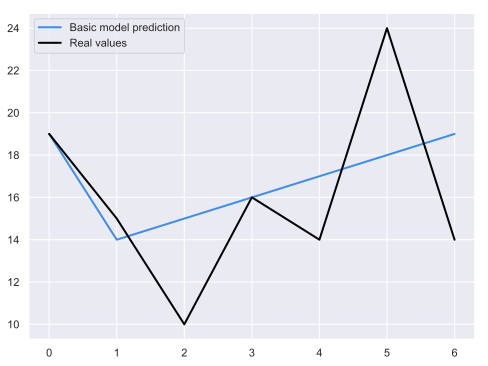

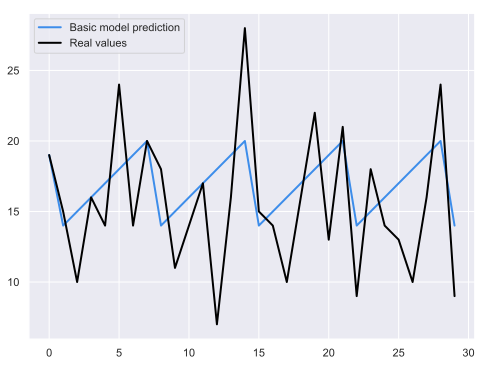

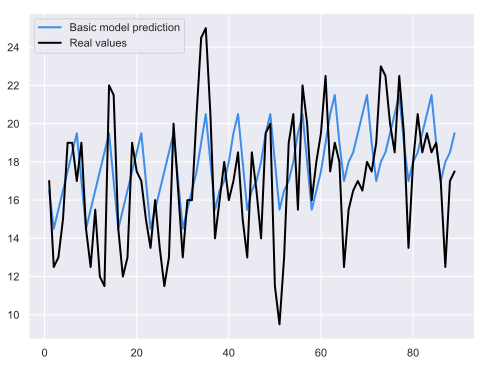

In [254]:
storeitem_col = f'item_{item}_store_{store}_sales'

for pl, mw in zip(plot_lengths, rolling_mean_windows):
    plt.plot(basic_pred[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['blue'],
             lw=2,
             label='Basic model prediction')
    """plt.plot(complex_pred[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['green'],
             lw=2, 
             label='Complex model prediction')"""
    plt.plot(real[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['black'],
             lw=2, 
             label='Real values')
    plt.legend(loc='upper left')
    plt.savefig(f'plot_prediction_{pl}_{mw}.svg')
    plt.show()